## First draft of Contrast algorithm

## To do
- ✔ Compute standard_distances for each cluster
- When updating st_dists of cluster, project along both infinite-stdev and
  0-stdev dims
- Update sensitivity -> how?
- Inverse law when seeing duplicates
- Implement context
- Compare stdevs and distances
- Clustering validity checking methods (Note: not necessarily relevant
  though)
- Recollection: random updates vs complete updates?
- Hub clusters
- Forgetting data

## Not to do
- Implement a tree-like structure for clusters (not relevant if we update
  only one outlier point we saw early)

## Imports

In [8]:
# import time
# import csv
# import matplotlib.pyplot as plt
# import matplotlib.cm as cm
import numpy as np
import seaborn as sns
import pandas as pd
from scipy.stats import chi2
from scipy.stats import special_ortho_group
from scipy.spatial.distance import mahalanobis
from sklearn import metrics
from utils import plot_confusion_matrix
import collections
import functools
import itertools

np.random.seed(1)

## Global variables and functions

In [9]:
NB_FEATURES = 5
NB_GROUPS = 3
N = 20
DOMAIN_LENGTH = 200
DEV_MAX = 20

COLORS = ['r', 'g', 'b', 'y', 'c', 'm']

# stocks metadata as (DATASET_NAME, DATASET_EXTENSION, DATASET_PATH,
#     \ DATASET_CLUSTER_COLUMN_INDEX, DATASET_DATA_COLUMNS_INDICES)
METADATA = {
    'Cards': ('Cards', '.csv', 'data/', 1, (2, None)),
    'Cards_truncated': ('Cards', '.csv', 'data/', 1, (2, 7))
}

SHOULD_LOAD_DATASET = 1  # 0 to generate, 1 to load
if SHOULD_LOAD_DATASET:
    NAME = 'Cards'
    DATASET_NAME, DATASET_EXTENSION, DATASET_PATH, \
        DATASET_CLUSTER_COLUMN_INDEX, \
        DATASET_DATA_COLUMNS_INDICES = METADATA[NAME]
    DATASET_PATH_FULL = DATASET_PATH + DATASET_NAME + DATASET_EXTENSION
else:
    DATASET_PATH = 'data/'
    DATASET_NAME = 'dummy'


def generate_cluster(n_cluster, nb_features=NB_FEATURES, d=DOMAIN_LENGTH,
                     dev_max=DEV_MAX, method='byhand'):
    """
    The 'method' argument can be one of the following:
    - 'byhand'
    - 'multinormal'
    """
    mean = np.random.random(nb_features) * d
    if method == 'multinormal':
        # /!\ does not work: data does not seem random at all, covariance is
        # always positive...!
        raise DeprecationWarning("beware, 'multinormal' method does not seem"
                                 "to work")
        cov = np.tril(np.random.random((nb_features, n_cluster)) *
                      np.random.random() * dev_max)
        cov = cov @ cov.transpose()  # a covariance matrix
        return(np.random.multivariate_normal(mean, cov, n_cluster))
    else:
        if method != 'byhand':
            print("generate_cluster: method unknown, using 'byhand'")
        st_devs = dev_max * np.random.random(nb_features)
        # holds the st_devs of each feature
        cluster_points = np.zeros((n_cluster, nb_features))
        for i in range(n_cluster):
            for j in range(nb_features):
                cluster_points[i][j] = np.random.normal(loc=mean[j],
                                                        scale=st_devs[j])
        cluster_points = cluster_points @ special_ortho_group.rvs(nb_features)
        return(cluster_points)


def generate_dataset(nb_groups=NB_GROUPS, n=N, nb_features=NB_FEATURES,
                     d=DOMAIN_LENGTH, dev_max=DEV_MAX):
    group_sizes = np.random.random(nb_groups)
    group_sizes *= n / np.sum(group_sizes)
    group_sizes = np.trim_zeros(np.round(group_sizes)).astype(int)
    data = [generate_cluster(n_cluster) for n_cluster in group_sizes]
    data = np.vstack(data)
    clusters_true = np.concatenate([n_cluster * [i] for i, n_cluster in
                                    enumerate(group_sizes)])
    np.save(DATASET_PATH + DATASET_NAME + '_data.npy', data)
    np.save(DATASET_PATH + DATASET_NAME + '_clusters_true.npy', clusters_true)

## The agent

In [43]:
class ContrastAgent(object):
    def __init__(self,
                 method_find='byhand',
                 method_multivariate='mmcd',
                 method_univariate='mad',
                 alpha=0.95,
                 ord=2,
                 sensitivenesses=[1, 10, 0.1],
                 shuffleToggle=False,
                 verbose=False):

        # --- user-defined parameters ---

        self.method_find = method_find
        self.method_multivariate = method_multivariate
        self.method_univariate = method_univariate
        self.ord = ord
        self.shuffleToggle = shuffleToggle
        self.verbose = verbose

        # # --- 'byhand' method specific paramters ---
        self.sensitiveness_find_cluster = sensitivenesses[0]
        # if a point is alone with a radius of
        # sensitiveness_find_cluster * stdist, create a new cluster

        self.sensitiveness_inf_dims = sensitivenesses[1]
        # sensitiveness to determine if a dimension is too variable to be
        # relevant for the cluster

        self.sensitiveness_zero_dims = sensitivenesses[2]
        # sensitiveness to determine if a dimension is too concentrated to be
        # relevant for the cluster

        # # --- 'maha' method specific parameters ---
        self.alpha = alpha

        # --- self-initialized parameters ---
        self.allZeros = True
        self.clusters = np.array([])
        # clusters[i] == j means that point i belongs to cluster j
        self.cluster_sizes = []
        self.data = np.array([[]])
        self.first_time = True  # is True if nb
        self.nb_clusters = 0
        self.nb_seen = 0
        self.permutation = None
        self.stdist = 0
        self.stdists_per_cluster = []

    def clusterize_online(self):
        assert len(self.data), "empty data"
        if self.nb_clusters == 0:
            self.new_cluster(0)
            self.one_more_seen()
        for i, p in enumerate(self.data[self.nb_seen:], start=self.nb_seen):
            self.find_cluster(i, p, until=i)
            if not self.allZeros:
                self.one_more_seen()

    def distance(self, p, q, ord=2):
        return(np.linalg.norm(p-q, self.ord))

    def feed_data(self, d):
        """Adds data to the agent's memory"""
        d2 = np.copy(d)
        if self.shuffleToggle:
            d2 = self.shuffle(d2)
        if self.nb_clusters == 0:
            self.data = np.copy(d2)
            self.clusters = np.zeros(len(d2), dtype=int)
            self.clusters.fill(-1)
        else:
            new_data = np.vstack((self.data, d2))
            self.data = new_data
            new_clusters = np.zeros(len(data), dtype=int)
            new_clusters.fill(-1)
            new_clusters_all = np.hstack((self.clusters, new_clusters))
            self.clusters = new_clusters_all

    def find_cluster(self, i, p, until=None, recollection=False):
        """
        The 'method' argument can be on the following:
        'byhand', 'byhand-naive', 'maha', 'cook', 'mmcd'.
        """
        method = self.method_find
        if method in ['maha', 'cook', 'mmcd']:
            global_ratio = self.get_outlier_ratio(p, self.data)
            if global_ratio > 1:
                self.new_cluster(i)
            else:
                cluster_ratios = []
                for j, size in enumerate(self.cluster_sizes):
                    if size != 0:
                        cluster_points = self.get_cluster_points(j)
                        ratio = self.get_outlier_ratio(p, cluster_points)
                        cluster_ratios.append([j, ratio])
                cluster_ratios = np.array(cluster_ratios)
                bci = np.argmin(cluster_ratios[:, 1])
                bc = cluster_ratios[bci, 0]
                self.clusters[i] = bc
                if self.verbose:
                    print(cluster_ratios)
                    print("Best cluster is {} with a ratio of {}".format(
                        bc, cluster_ratios[bci, 1]))
                    print("{} -> cluster of {}".format(i, bc))
        elif method == 'byhand-naive':
            distances = np.array([self.distance(p, q, ord) for q
                                  in self.data[:until]])
            self.allZeros = self.allZeros and np.all(distances == 0)
            dist_min = np.min(np.trim_zeros(distances)) if not self.allZeros \
                else 0
            closest = np.argmin(distances)
            if dist_min > self.sensitiveness_find_cluster * self.stdist and \
                    0 not in distances:
                self.new_cluster(i)
            else:
                if self.verbose:
                    print("{} -> cluster of {}".format(i, closest))
                self.clusters[i] = self.clusters[closest]
                if not self.allZeros:
                    self.update_stdists_per_cluster(self.clusters[i], p)
                self.cluster_sizes[self.clusters[i]] += 1
            if not recollection and not self.allZeros:
                self.update_stdist(self.nb_seen, dist_min)
        else:
            p_i = i  # Variable i will be replaced afterwards, watch out!
            if method != 'byhand':
                print("find_cluster: unknown method, using 'byhand'")
            cluster_indexes = []
            cluster_dims = []
            cluster_good_ratios_sum = []
            cluster_bad_ratios_sum = []
            for i in self.clusters:
                if i != -1:
                    relevant_dims, good_ratios_sum, bad_ratios_sum, ratios = \
                            self.get_cluster_analysis(i, p)
                    cluster_indexes.append(i)
                    cluster_dims.append(relevant_dims)
                    cluster_good_ratios_sum.append(good_ratios_sum)
                    cluster_bad_ratios_sum.append(bad_ratios_sum)
            ind = np.lexsort((cluster_indexes,
                              cluster_bad_ratios_sum,
                              cluster_good_ratios_sum,
                              -np.array(cluster_dims)))
            closest = cluster_indexes[ind[0]]
            if self.verbose:
                print([(cluster_dims[i],
                        cluster_good_ratios_sum[i],
                        cluster_bad_ratios_sum[i],
                        cluster_indexes[i])
                       for i in ind[0: min(len(ind), 3)]])
            if cluster_dims[ind[0]] == 0 or \
                    self.nb_clusters == 1:
                self.new_cluster(p_i)
            else:
                closest_second = cluster_indexes[ind[1]]
                cluster_fusion = np.vstack([
                    self.get_cluster_points(closest),
                    self.get_cluster_points(closest_second)
                    ])
                ratio_fusion = self.get_outlier_ratio(
                        p, cluster_fusion, alpha=self.alpha,
                        method=self.method_multivariate)
                if ratio_fusion > 10:
                    self.new_cluster(p_i)
                else:
                    if self.verbose:
                        print("{} -> cluster of {}".format(p_i, closest))
                    self.clusters[p_i] = self.clusters[closest]
                    self.cluster_sizes[self.clusters[p_i]] += 1

    def get_cluster_analysis(self, i, p, custom_points=[]):
        relevant_dims = 0
        good_ratios_sum = 0
        bad_ratios_sum = 0
        ratios = self.get_outlier_ratio_per_dimension(i, p, custom_points)
        for r in ratios:
            if r < 1:
                relevant_dims += 1
                good_ratios_sum += r
            else:
                bad_ratios_sum += r
        return(relevant_dims, good_ratios_sum, bad_ratios_sum, ratios)

    def get_cluster_relevant_dimensions(self, i):
        """ return (relevant_dims, inf_dims, zero_dims) """
        stdist_i = self.stdists_per_cluster[i]
        cluster_points = self.get_cluster_points(i)
        relevant_dims, inf_dims, zero_dims = [], [], []
        for j in range(cluster_points.shape[1]):
            stdev = np.std(cluster_points[:, j])
            if stdev > self.sensitiveness_inf_dims * stdist_i:
                inf_dims.append(j)
            elif stdev < self.sensitiveness_zero_dims * stdist_i:
                zero_dims.append(j)
            else:
                relevant_dims.append(j)
        return relevant_dims, inf_dims, zero_dims

    def get_cluster_points(self, i):
        return self.data[np.nonzero(self.clusters == i)]

    def get_nb_obs_per_dimension(self, i):
        """ returns the number of distinct observations per dimension """
        cluster_points = self.get_cluster_points(i)
        d = cluster_points.shape[1]
        nb_obs = np.zeros(d)
        for j in range(d):
            nb_obs[j] = len(np.unique(cluster_points[:, j]))
        return nb_obs

    def get_outlier_ratio_per_dimension(self, i, p, custom_points=[]):
        cluster_points = self.get_cluster_points(i)
        if len(custom_points) > 0:
            cluster_points = custom_points
        d = cluster_points.shape[1]
        if d == 1:
            np.hstack(cluster_points, np.mean(cluster_points,
                                              np.reshape(p, (-1, 1))))
            # arbitrary choice: we add the mean to get a more relevant result
        ratios = np.zeros(d)
        for j in range(d):
            ratios[j] = self.get_outlier_ratio_univariate(
                    p[j], cluster_points[:, j], method=self.method_univariate)
        return ratios

    def get_outlier_ratio(self, p, cluster_points_without_p, alpha=0.95,
                          method='maha', h=0.75, m=5):
        """
        The 'method' argument can be either of the following:
        - 'maha': Mahalanobis distance, generalization of the distance to
                  the mean in terms of standard deviations for
                  multivariate data
        - 'cook': TODO
        - 'mmcd': TODO

        If return value > 1, consider p an outlier
        """
        eps = np.mean(cluster_points_without_p[0]) * 1e-6
        # used to avoid singular matrices
        cluster_points = np.vstack([p, cluster_points_without_p])
        n = len(cluster_points)
        threshold = chi2.isf(1-alpha, len(p))
        if method == 'cook':
            raise NotImplementedError("'cook' method not yet implemented")
        elif method == 'mmcd':
            sample_size = int(h * n)
            permutations = np.zeros((m, sample_size), dtype=int)
            determinants = np.zeros(m)
            for i in range(m):
                permutations[i] = np.random.permutation(n)[:sample_size]
                for j in range(m):
                    sample = cluster_points[permutations[i]]
                    sigma = np.cov(sample, rowvar=False) + \
                        eps * np.eye(len(p))
                    mu = np.mean(sample, axis=0)
                    distances = [mahalanobis(point, mu, np.linalg.inv(sigma))
                                 for point in cluster_points]
                    permutations[i] = np.argsort(distances)[:sample_size]
                determinants[i] = np.linalg.det(sigma)
            best = np.argmin(determinants)
            sample = cluster_points[permutations[best]]
            sigma = np.cov(sample, rowvar=False) + eps * np.eye(len(p))
            mu = np.mean(sample, axis=0)
            d = mahalanobis(p, mu, np.linalg.inv(sigma))
            ratio = d / threshold
            return ratio
        else:
            if method != 'maha':
                print("Unknown method, using Mahalanobis distance")
            sigma = np.cov(cluster_points, rowvar=False) + eps * np.eye(len(p))
            mu = np.mean(cluster_points, axis=0)
            d = mahalanobis(p, mu, np.linalg.inv(sigma))
            ratio = d / threshold
            return ratio

    def get_outlier_ratio_univariate(self, p, cluster_points_without_p,
                                     B=1.4826, threshold=3, method='mad'):
        """
        The 'method' argument can be one of the following:
        - 'mean': mean +- three stdevs
        - 'mad': median absolute deviation, more robust to detect outliers

        If the value returned is > 1, consider p an outlier.
        """
        cluster_points = np.hstack([cluster_points_without_p, [p]])
        if method == 'mean':
            raise NotImplementedError("'mean' method not yet implemented")
        else:
            if method != 'mad':
                print("Unknown method_univariate, using median "
                      "absolute deviation")
            m = np.median(cluster_points)
            mad = B * np.median(np.abs(cluster_points - m))
            if np.abs(p-m) == 0:
                return 0
            elif mad == 0:
                return np.inf
            else:
                return (np.abs(p-m)/(threshold*mad))

    def new_cluster(self, p_i):
        if self.clusters[p_i] == -1 or \
                not self.cluster_sizes[self.clusters[p_i]] == 1:
            if self.verbose:
                print("{} -> new cluster".format(p_i))
            self.clusters[p_i] = self.nb_clusters
            self.nb_clusters += 1
            self.cluster_sizes.append(1)
            self.stdists_per_cluster.append(0)

    def one_more_seen(self):
        self.nb_seen += 1

    def print_clusters(self):
        columns = ["d" + str(i) for i in range(self.data.shape[1])] \
                  + ['affected cluster']
        df_1 = pd.DataFrame(np.hstack((self.data,
                                       np.reshape([self.clusters],
                                                  (self.data.shape[0], 1)))),
                            columns=columns)
        agent_plot = sns.pairplot(df_1, kind="scatter", hue="affected cluster",
                                  vars=columns[:-1])
        agent_plot.savefig(DATASET_PATH + DATASET_NAME + '_agent.png')

    def print_scores(self):
        pass

    def shuffle(self, data_to_shuffle):
        assert self.shuffleToggle, \
            "agent: shuffle method called but shuffleToggle is False"
        new_permutation = np.random.permutation(len(data_to_shuffle))
        if self.permutation is None:
            self.permutation = new_permutation
        else:
            new_permutation2 = new_permutation + len(self.permutation)
            self.permutation = np.concatenate([self.permutation,
                                               new_permutation2])
        return(data_to_shuffle[new_permutation])

    def update_clusters(self, until_update=None, until_dist=None,
                        recollection=True):
        for i, p in enumerate(self.data[:until_update]):
            self.find_cluster(i, p, until=until_dist,
                              recollection=recollection)

    def update_stdist(self, nb_seen, distance):
        old_dist = self.stdist
        self.stdist = (max(1, nb_seen-1) * self.stdist + distance) / (nb_seen)
        if self.verbose:
            print('distance = {}, self.stdist = {} -> {}'.format(
                distance, old_dist, self.stdist))

    def update_stdists_per_cluster(self, i, p):
        old_dist = self.stdists_per_cluster[i]
        relevant_dims, inf_dims, zero_dims = self.get_cluster_dimensions(i)
        if len(relevant_dims):
            cluster_points_rd = self.get_cluster_points(i)[:, relevant_dims]
            p_rd = p[relevant_dims]
        elif len(inf_dims):
            cluster_points_rd = self.get_cluster_points(i)[:, inf_dims]
            p_rd = p[inf_dims]
        else:
            cluster_points_rd = self.get_cluster_points(i)[:, zero_dims]
            p_rd = p[zero_dims]
        array_dists = np.array([self.distance(p_rd, q) for q in
                                cluster_points_rd])
#         print(relevant_dims, inf_dims, zero_dims)
#         print(array_dists)
        dist_p = np.min(array_dists)
        csize = cluster_points_rd.shape[0]
        self.stdists_per_cluster[i] = (old_dist * csize + dist_p) / (csize + 1)

## Generate or load dataset

In [44]:
if SHOULD_LOAD_DATASET:
    start, end = DATASET_DATA_COLUMNS_INDICES
    df1 = pd.read_csv(DATASET_PATH_FULL)
    df1_np = df1.to_numpy(copy=True)
    data = df1_np[:, start:end].astype('float')
    clusters_true = df1_np[:, DATASET_CLUSTER_COLUMN_INDEX]
else:
    generate_dataset()
    data = np.load(DATASET_PATH + DATASET_NAME + '_data.npy')
    clusters_true = np.load(DATASET_PATH + DATASET_NAME +
                            '_clusters_true.npy').astype(int)

assert data is not None, 'data is None'
assert clusters_true is not None, 'clusters_true is None'

# print(data)
# print(clusters_true)

## Preview dataset

/home/ashikaga/miniconda3/envs/ml/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/ashikaga/miniconda3/envs/ml/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


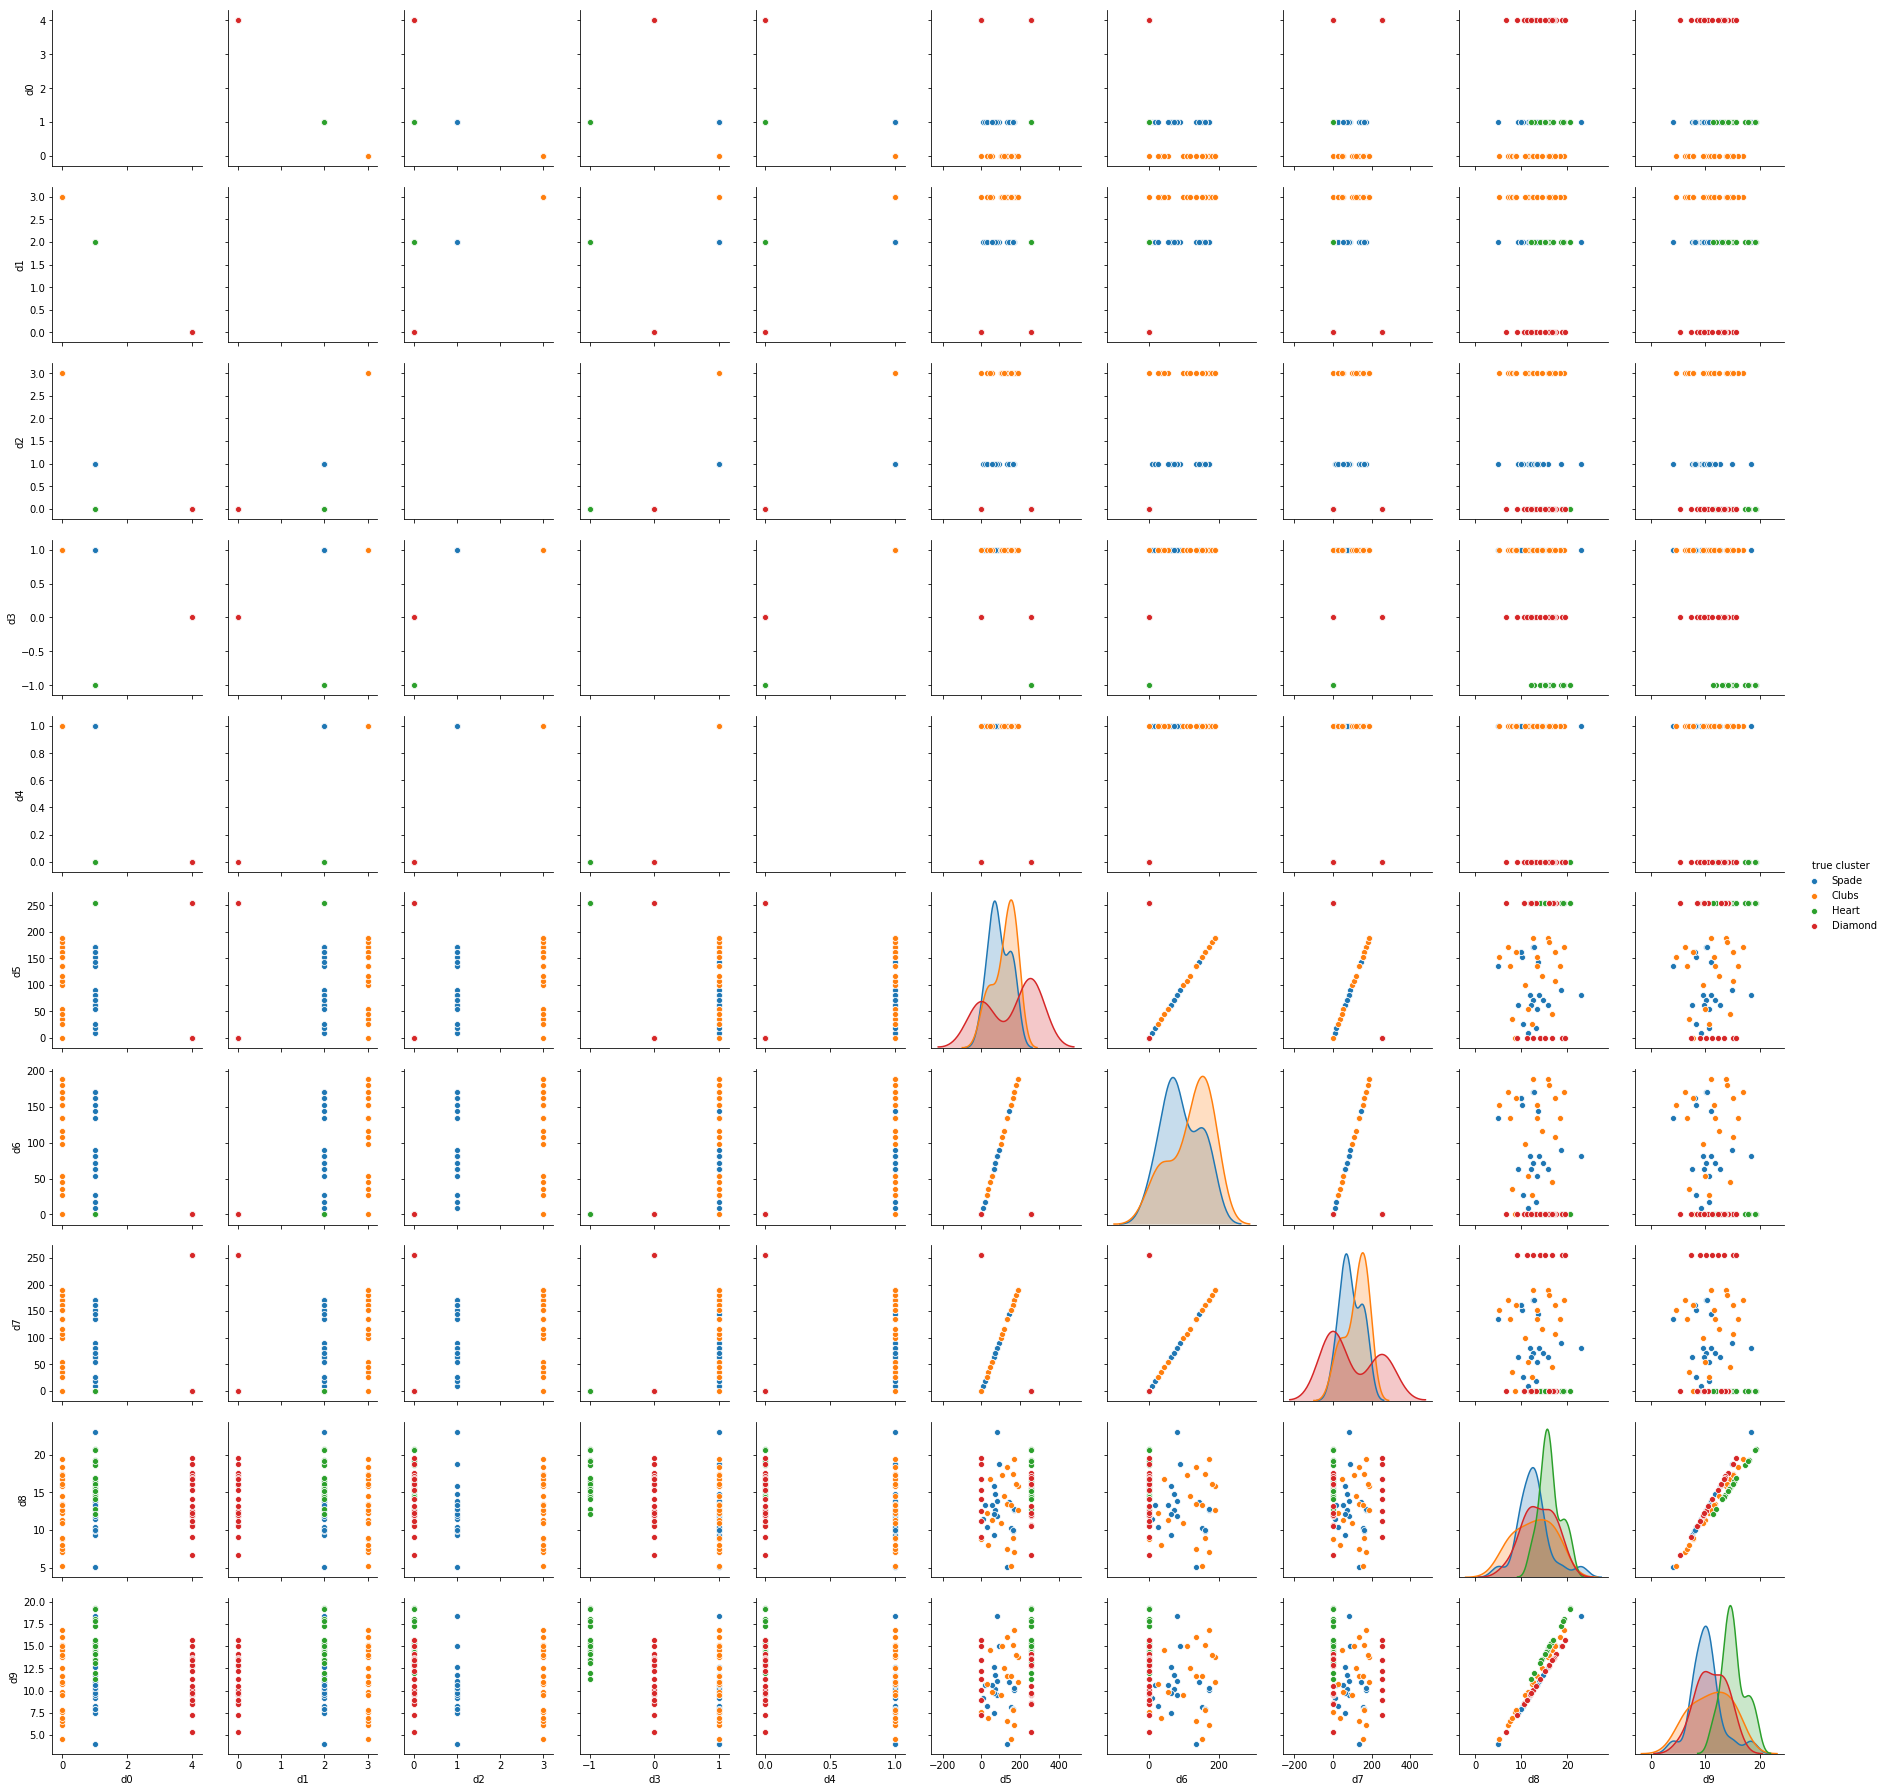

In [15]:
columns = ["d" + str(i) for i in range(data.shape[1])] + ['true cluster']
df = pd.DataFrame(np.hstack((data, np.reshape([clusters_true],
                                              (data.shape[0], 1)))),
                  columns=columns)
true_data_plot = sns.pairplot(df, kind="scatter", hue='true cluster',
                              vars=columns[:-1])
true_data_plot.savefig(DATASET_PATH + DATASET_NAME + '_true.png')

## Clusterize

0 -> new cluster
[(10, 1.1241512657943256, 0, 0)]
1 -> new cluster
[(10, 1.1241512657943253, 0, 0), (10, 1.1241512657943256, 0, 1)]
2 -> new cluster
[(10, 1.1241512657943253, 0, 1), (10, 1.1241512657943253, 0, 2), (10, 1.1241512657943256, 0, 0)]
3 -> cluster of 1
[(10, 1.1241512657943253, 0, 2), (10, 1.1241512657943258, 0, 0), (10, 2.1702494284864726, 0, 1)]
4 -> cluster of 2
[(10, 0.44966050631773014, 0, 0), (10, 0.6744907594765953, 0, 2), (10, 0.6744907594765953, 0, 2)]
5 -> cluster of 0
[(10, 0.6744907594765953, 0, 2), (10, 0.6744907594765953, 0, 2), (10, 1.1241512657943256, 0, 1)]
6 -> cluster of 2
[(10, 1.2538815247575457, 0, 2), (10, 1.2538815247575457, 0, 2), (10, 1.2538815247575457, 0, 2)]
7 -> cluster of 2
[(10, 0.8931016418703466, 0, 1), (10, 0.8931016418703466, 0, 1), (10, 1.1241512657943253, 0, 2)]
8 -> cluster of 1
[(10, 0.10453890751972689, 0, 1), (10, 0.10453890751972689, 0, 1), (10, 0.10453890751972689, 0, 1)]
9 -> cluster of 1
[(10, 1.1241512657943256, 0, 2), (10, 1.12

/home/ashikaga/miniconda3/envs/ml/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/ashikaga/miniconda3/envs/ml/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


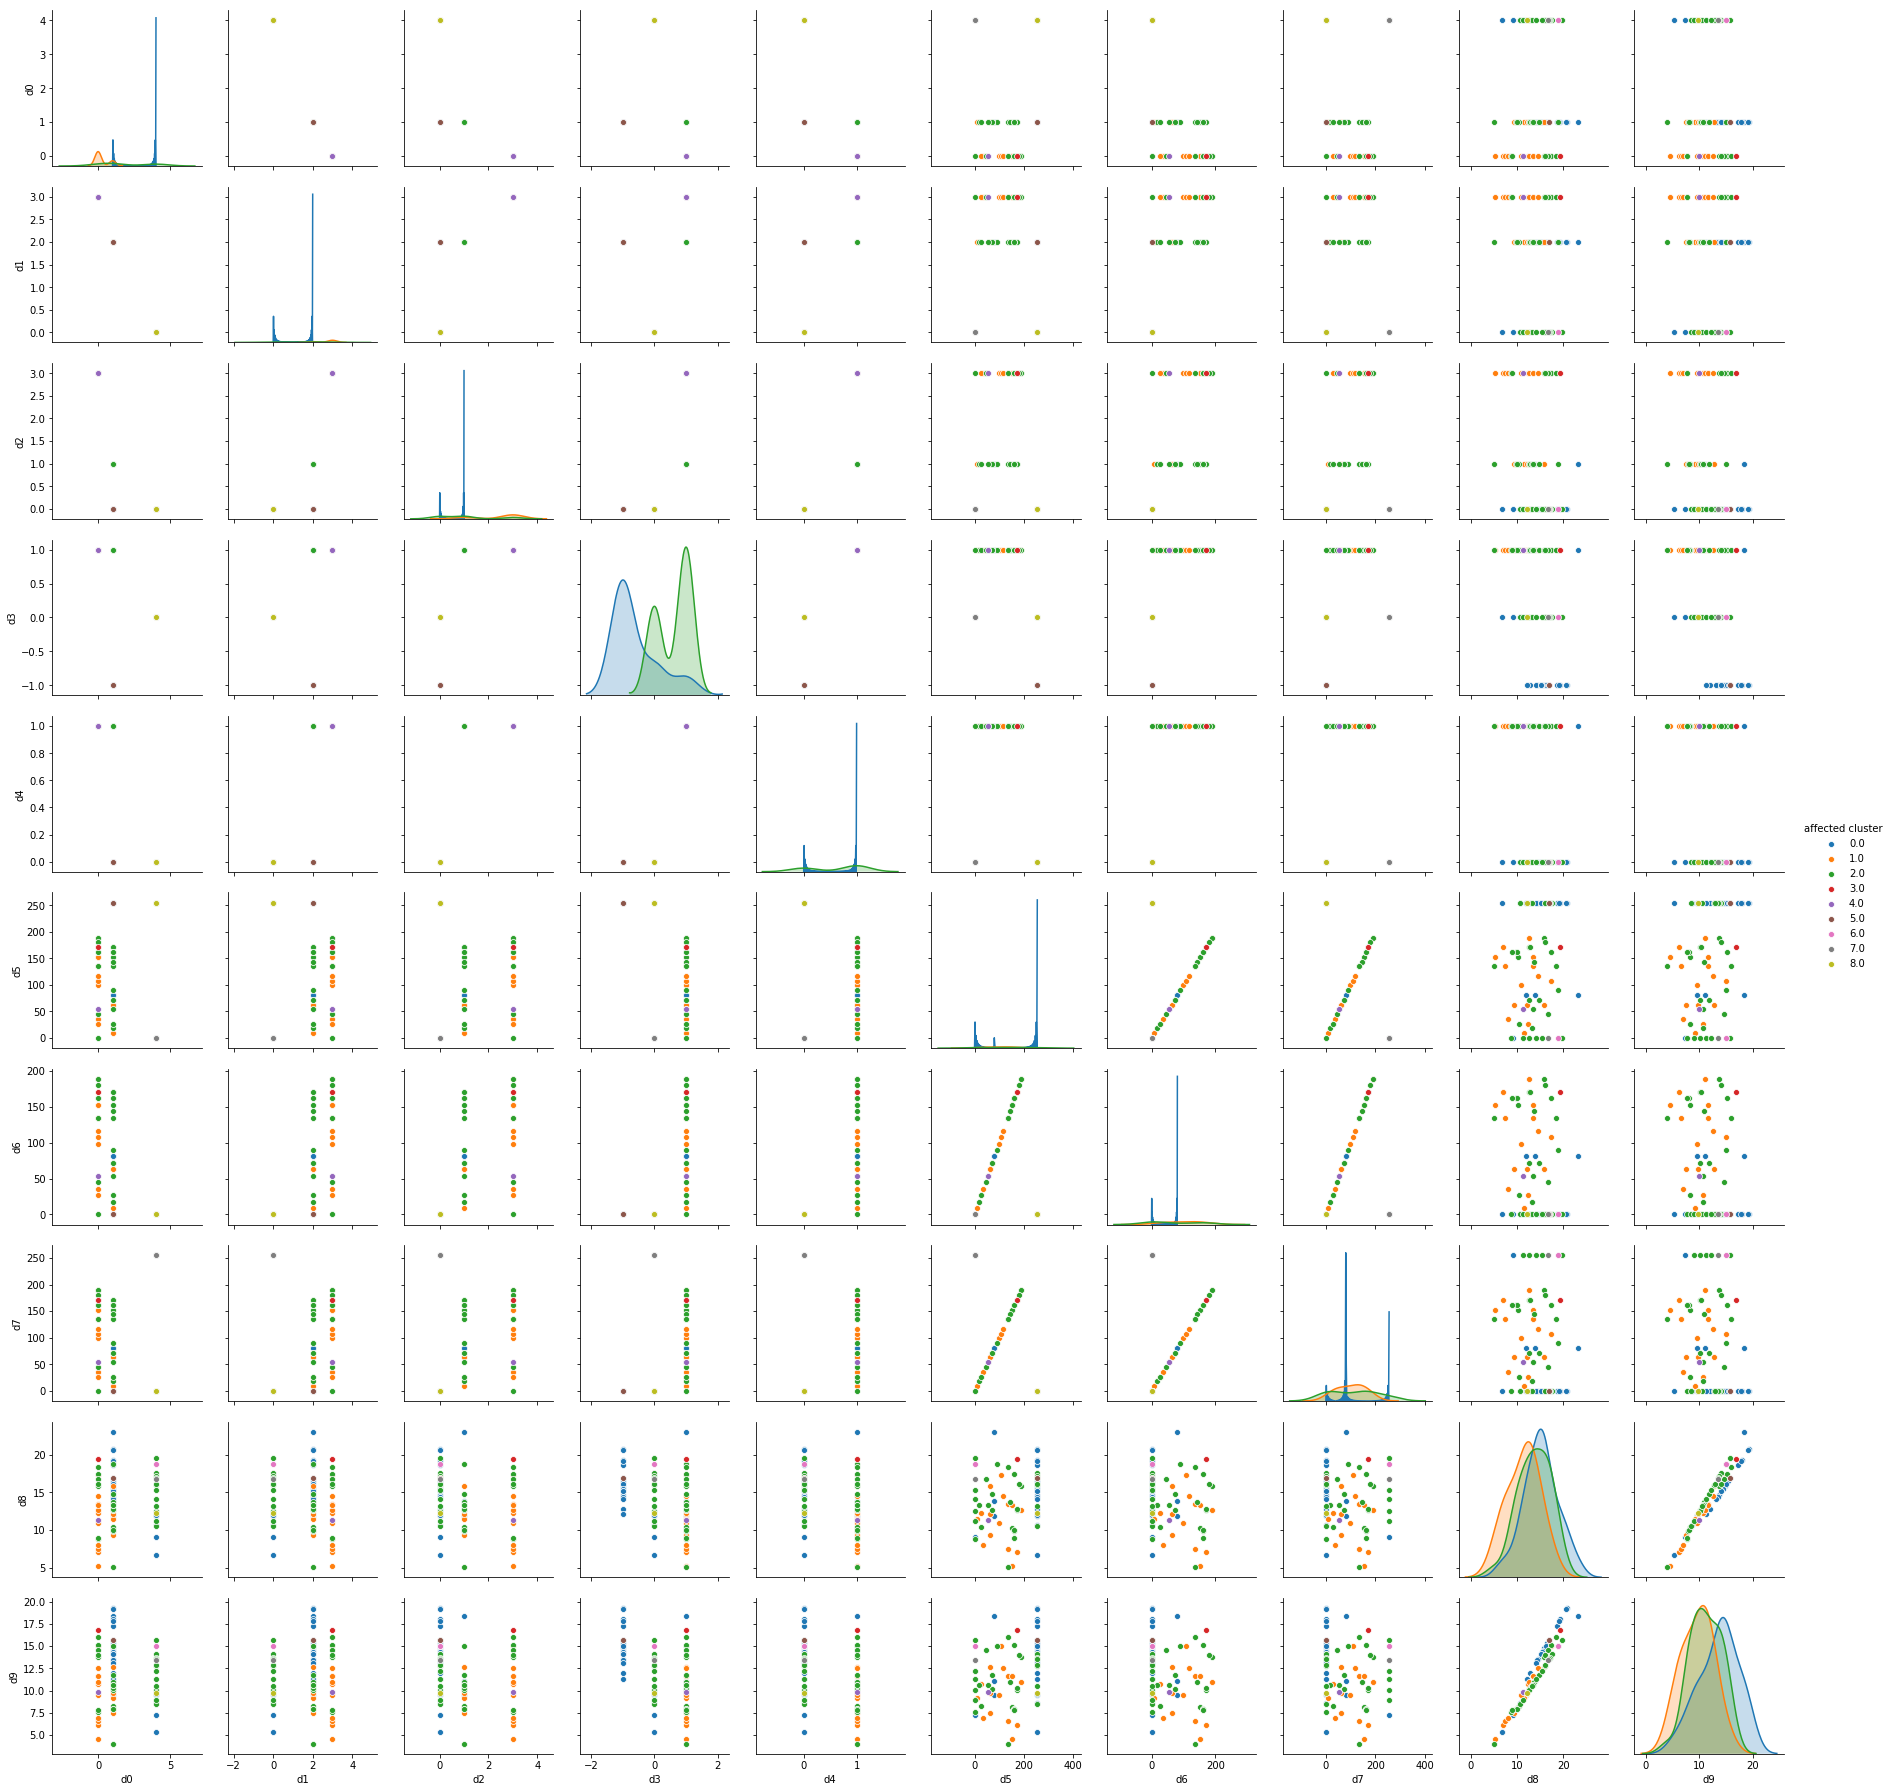

In [46]:
ca = ContrastAgent(method_find='byhand', sensitivenesses=[1.25, 10, 0.1],
                   shuffleToggle=False, verbose=True)
ca.feed_data(data)
ca.clusterize_online()
if ca.method_find == 'byhand-naive':
    print("Final stdist: {}".format(ca.stdist))
print("All points in a cluster? {}".format(-1 not in ca.clusters))
ca.print_clusters()

## Performance metrics

In [47]:
def print_metrics():
    if clusters_true is not None:
        # clusters_true2 will contain ids instead of labels
        ids = collections.defaultdict(functools.partial(next,
                                                        itertools.count()))
        clusters_true2 = np.array([ids[label] for label in clusters_true])
        if ca.shuffleToggle:
            clusters_true2 = clusters_true2[ca.permutation]
        print("--- Metrics involving ground truth--- ")
        print("Adjusted Rand Index: {}".format(
            metrics.adjusted_rand_score(clusters_true2, ca.clusters)))
        print("Adjusted Mutual Information score: {}".format(
            metrics.adjusted_mutual_info_score(clusters_true2, ca.clusters)))
        print("Homogeneity: {}".format(
            metrics.homogeneity_score(clusters_true2, ca.clusters)))
        print("Completeness: {}".format(
            metrics.completeness_score(clusters_true2, ca.clusters)))
        print("V-measure score: {}".format(
            metrics.v_measure_score(clusters_true2, ca.clusters)))
        print("Fowlkes-Mallows score: {}".format(
            metrics.fowlkes_mallows_score(clusters_true2, ca.clusters)))
        print()

    print("--- Metrics not involving ground truth ---")
    if clusters_true is not None:
        print("Silhouette score (original): {}".format(
            metrics.silhouette_score(data, clusters_true)))
    print("Silhouette score (agent): {}".format(
        metrics.silhouette_score(ca.data, ca.clusters)))
    if clusters_true is not None:
        print("Calinski-Harabaz score (original): {}".format(
            metrics.calinski_harabaz_score(data, clusters_true)))
    print("Calinski-Harabaz score (agent): {}".format(
        metrics.calinski_harabaz_score(ca.data, ca.clusters)))
    if clusters_true is not None:
        print("Davies-Bouldin score (original): {}".format(
            metrics.davies_bouldin_score(data, clusters_true)))
    print("Davies-Bouldin score (agent): {}".format(
        metrics.davies_bouldin_score(ca.data, ca.clusters)))

    if clusters_true is not None:
        print()
        class_names = np.array([str(i) for i in range(1+np.max(
            np.concatenate([clusters_true2, ca.clusters])))])
        plot_confusion_matrix(
            clusters_true2, ca.clusters, classes=class_names,
            normalize=True, title='Normalized confusion matrix',
            path=DATASET_PATH + DATASET_NAME)

--- Metrics involving ground truth--- 
Adjusted Rand Index: 0.28871931524547806
Adjusted Mutual Information score: 0.3501569389685022
Homogeneity: 0.41825204902117824
Completeness: 0.42149512179665033
V-measure score: 0.41986732309485564
Fowlkes-Mallows score: 0.4820128168367202

--- Metrics not involving ground truth ---
Silhouette score (original): 0.1312928628658776
Silhouette score (agent): -0.7574220004204836
Calinski-Harabaz score (original): 18.441347854680224
Calinski-Harabaz score (agent): 5.290400233022169
Davies-Bouldin score (original): 2.5569270994140307
Davies-Bouldin score (agent): 2.2134465129338845

Normalized confusion matrix
[[0.15 0.2  0.65 0.   0.   0.   0.   0.   0.  ]
 [0.   0.55 0.35 0.05 0.05 0.   0.   0.   0.  ]
 [0.95 0.   0.   0.   0.   0.05 0.   0.   0.  ]
 [0.25 0.   0.6  0.   0.   0.   0.05 0.05 0.05]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   

/home/ashikaga/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/ashikaga/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/home/ashikaga/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/home/ashikaga/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/run/media/ashikaga

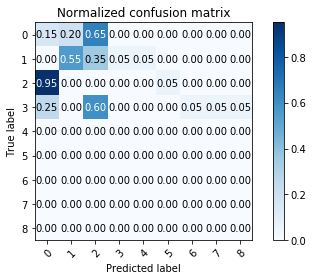

In [48]:
print_metrics()

[(10, 1.7382066791046973, 0, 2), (10, 1.7382066791046973, 0, 2), (10, 1.7382066791046973, 0, 2)]
0 -> cluster of 2
[(10, 0.9789351905656275, 0, 2), (10, 0.9789351905656275, 0, 2), (10, 0.9789351905656275, 0, 2)]
1 -> cluster of 2
[(10, 1.4319559412527163, 0, 2), (10, 1.4319559412527163, 0, 2), (10, 1.4319559412527163, 0, 2)]
2 -> cluster of 2
[(10, 1.0419853067403304, 0, 2), (10, 1.0419853067403304, 0, 2), (10, 1.0419853067403304, 0, 2)]
3 -> cluster of 2
[(10, 0.9873773823328316, 0, 2), (10, 0.9873773823328316, 0, 2), (10, 0.9873773823328316, 0, 2)]
4 -> cluster of 2
[(10, 0.48368307773229074, 0, 2), (10, 0.48368307773229074, 0, 2), (10, 0.48368307773229074, 0, 2)]
5 -> cluster of 2
[(10, 0.3568493274461275, 0, 2), (10, 0.3568493274461275, 0, 2), (10, 0.3568493274461275, 0, 2)]
6 -> cluster of 2
[(10, 0.828365662186771, 0, 2), (10, 0.828365662186771, 0, 2), (10, 0.828365662186771, 0, 2)]
7 -> cluster of 2
[(10, 0.6607110096774018, 0, 2), (10, 0.6607110096774018, 0, 2), (10, 0.66071100

/home/ashikaga/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/ashikaga/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/home/ashikaga/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/home/ashikaga/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/run/media/ashikaga

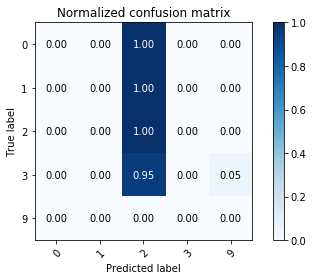

In [49]:
ca.update_clusters()
print_metrics()